In [36]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb

from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report

# Pipelines
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe

# Handling class imbalance
from imblearn.over_sampling import SMOTE

In [38]:
# Load churn dataset
df = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Customer-Churn-Prediction-/master/Resources/Analytical_Base_Table.csv")

# Quick overview
print(df.head())
print(df.info())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditSc

# Define Target & Features

In [39]:
# Target variable (example: 'Churn')
target = "Exited"

# Convert target to numeric if needed
le = LabelEncoder()
df[target] = le.fit_transform(df[target])  # Yes/No → 1/0

X = df.drop(columns=[target])
y = df[target]

# Identify Numerical & Categorical Columns

In [40]:
# Numerical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Categorical columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# Preprocessing Pipeline

In [42]:
# Numerical features → Scaling
num_transformer = make_pipeline(
    MinMaxScaler()
    )

# Categorical features → One-hot encoding
cat_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")
    )

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
            ("num", num_transformer, num_cols),
            ("cat", cat_transformer, cat_cols)
                ]
                )

# Train-Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
      X,
          y,
              test_size=0.3,
                  random_state=42,
                      stratify=y
                      )

print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 5574, 1: 1426})


In [46]:
random_state = 10

# Split X and y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=df.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


# Define XGBoost Model

In [49]:
xgb_clf = xgb.XGBClassifier(
      objective="binary:logistic",
          eval_metric="logloss",
              use_label_encoder=False,
                  random_state=42
                  )

# Build Full ML Pipeline (Preprocessing + SMOTE + Model)

In [51]:
model_pipeline = imbl_pipe(
      preprocessor,          # Feature preprocessing
          SMOTE(random_state=42),# Handle class imbalance
              xgb_clf                # XGBoost classifier
              )

# Hyperparameter Tuning (GridSearchCV)

In [53]:
param_grid = {
      "xgbclassifier__n_estimators": [100, 200],
          "xgbclassifier__max_depth": [3, 5, 7],
              "xgbclassifier__learning_rate": [0.01, 0.1],
                  "xgbclassifier__subsample": [0.8, 1.0],
                      "xgbclassifier__colsample_bytree": [0.8, 1.0]
                      }

In [55]:
grid_search = GridSearchCV(
      estimator=model_pipeline,
          param_grid=param_grid,
              scoring="f1",
                  cv=5,
                      n_jobs=-1,
                          verbose=2
                          )

# Train the Model

In [56]:
grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:36:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters:
{'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}


# Model Evaluation

In [57]:
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[2146  243]
 [ 235  376]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2389
           1       0.61      0.62      0.61       611

    accuracy                           0.84      3000
   macro avg       0.75      0.76      0.76      3000
weighted avg       0.84      0.84      0.84      3000



In [59]:
print(grid_search.best_params_)

{'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__subsample': 0.8}


In [62]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2146  243]
 [ 235  376]]


In [63]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.9  0.1 ]
 [0.38 0.62]]


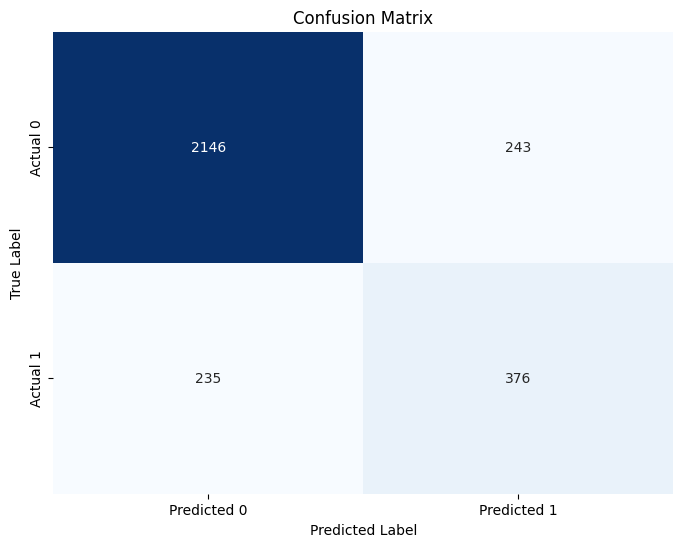

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()